In [ ]:


#| hide
from hybridpredictmaize22.GEMdataset import *


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [ ]:
path_snps = Path('data/snpCompress/')
data_path = Path('data/')

path_train_weatherTable =data_path/'Training_Data/4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'Training_Data/1_Training_Trait_Data_2014_2021.csv'

In [ ]:
for p in path_snps.iterdir():
    print(p)
     

data/snpCompress/EVEN_10
data/snpCompress/EVEN_100
data/snpCompress/EVEN_50
data/snpCompress/PCS_10
data/snpCompress/PCS_50


In [ ]:
#| export
class ST():
    """
    A class which will hold the secondary trait data for the entire dataset for pre-training purposes
    
    init
        yield_data -> pandas table
        testYear -> e.g. 2019. this will set all data from a given year as the Test Set
    """
    def __init__(self, yield_data, testYear):

        self.Te = yield_data.iloc[([str(testYear) in x for x in yield_data['Env']]),:].reset_index()
        self.Tr = yield_data.iloc[([str(testYear) not in x for x in yield_data['Env']]),:].reset_index()

        self.secondary_traits = [
                'Stand_Count_plants',
                'Pollen_DAP_days',
                'Silk_DAP_days',
                'Plant_Height_cm',
                'Ear_Height_cm',
                #'Root_Lodging_plants',
                #'Stalk_Lodging_plants',
                'Twt_kg_m3',
                'Yield_Mg_ha',
                #'Date_Harvested'
                ]
        
        self.setup_scaler()
        self.scale_data(self.Tr)
        self.scale_data(self.Te)

    def setup_scaler(self):
        ss = StandardScaler()
        ss.fit(np.array(self.Tr[self.secondary_traits]))
        self.scaler = ss

    def scale_data(self,df):
        scaled_secondary = self.scaler.transform(np.array(df[self.secondary_traits]))
        for c,i in enumerate(self.secondary_traits):
            #print(i)
            df[i] = scaled_secondary[:,c]
    
    def plot_yields(self):
        for i in self.secondary_traits:
            plt.hist(self.Tr[i],density=True, label='Train',alpha=.5,bins=50)
            plt.hist(self.Te[i],density=True, label='Test',alpha=.5,bins=50)
            plt.legend()
            plt.title(i)
            plt.show()

In [ ]:
secondary_traits = [
                'Stand_Count_plants',
                'Pollen_DAP_days',
                'Silk_DAP_days',
                'Plant_Height_cm',
                'Ear_Height_cm',
                #'Root_Lodging_plants',
                #'Stalk_Lodging_plants',
                'Twt_kg_m3',
                'Yield_Mg_ha',
                #'Date_Harvested'
                ]
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data.dropna(subset=secondary_traits)

x = ST(yield_data,2019)

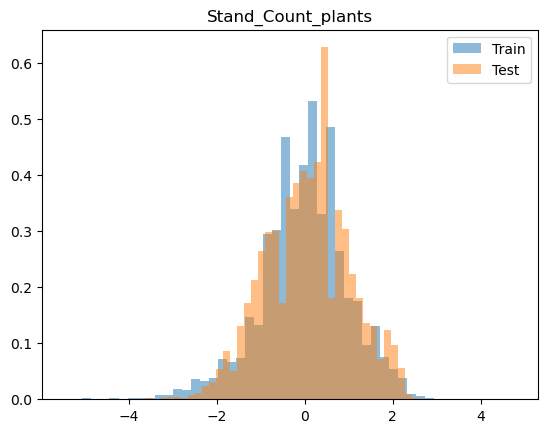

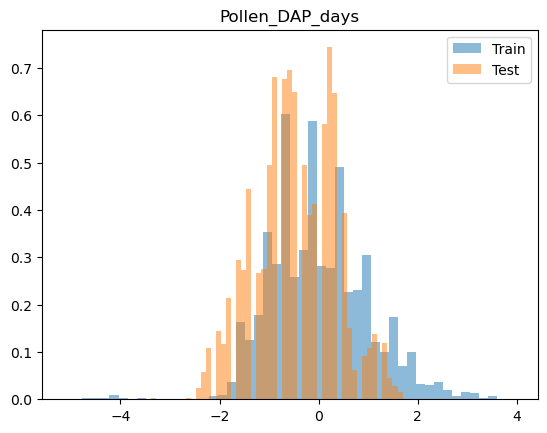

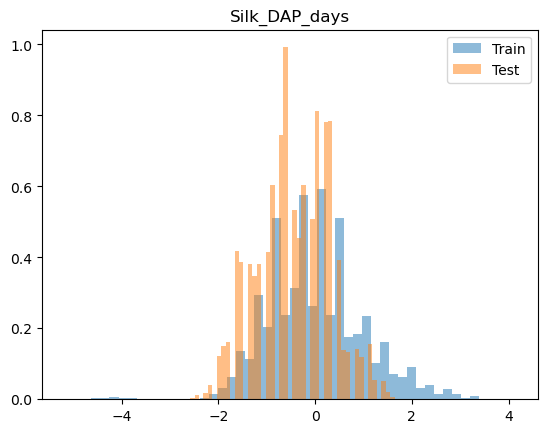

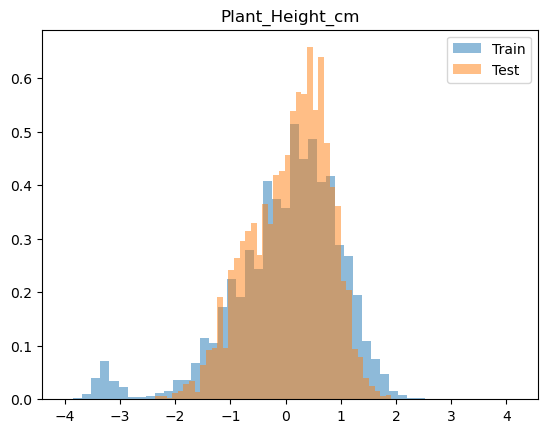

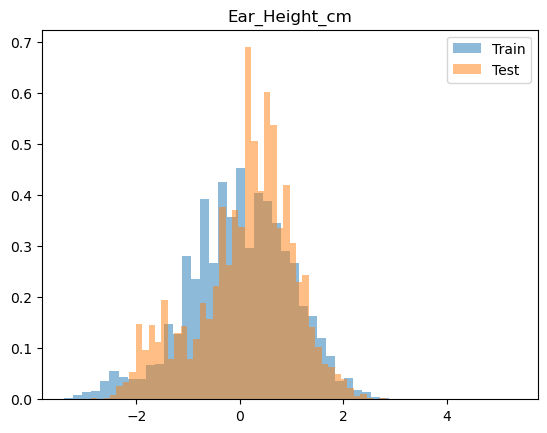

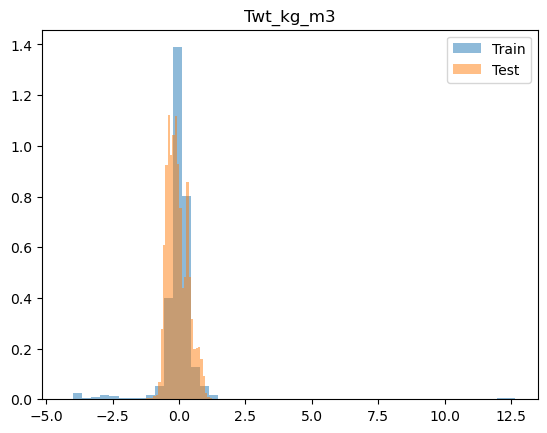

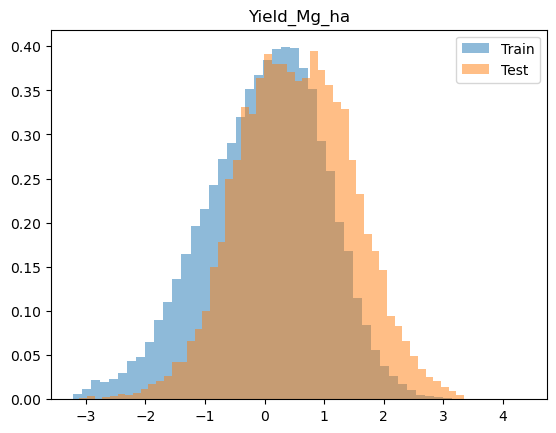

In [ ]:
x.plot_yields()

In [ ]:
second_t = ST(yield_data,2019)

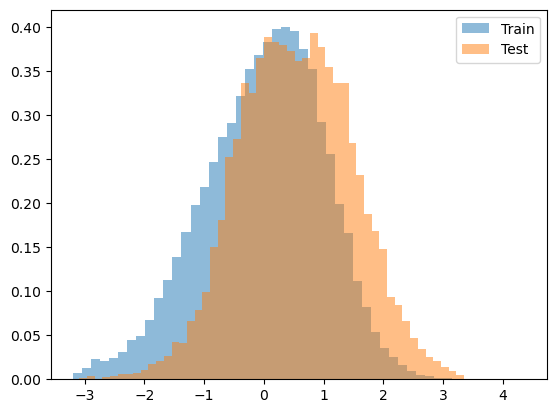

In [ ]:
second_t.plot_yields()

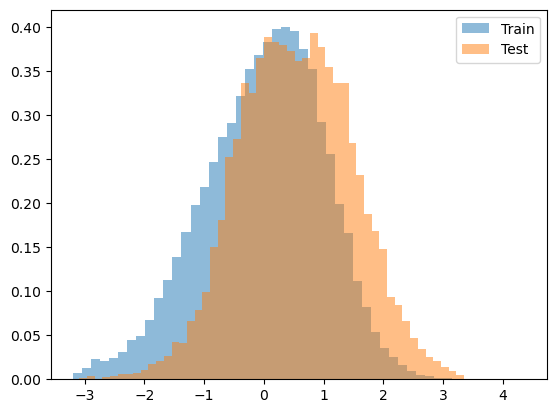

In [ ]:
snp_data = collect_snps(path_snps/'EVEN_10') # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 





# for yield
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields

#for secondary traits
#pre train
secondary_traits = [
'Stand_Count_plants',
'Pollen_DAP_days',
'Silk_DAP_days',
'Plant_Height_cm',
'Ear_Height_cm',
#'Root_Lodging_plants',
#'Stalk_Lodging_plants',
'Twt_kg_m3',
'Yield_Mg_ha',
'Date_Harvested'
]
yield_data = yield_data.dropna(subset=secondary_traits)


weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]

#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = collect_snps(path_snps/'PCS_10')

#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

gem.Y.plot_yields()


In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))


(-1.3272381606991435,
 array([-0.01253692, -0.01967193,  0.00168105,  0.00032169, -0.00813794,
         0.00743239,  0.0462733 ,  0.01858733,  0.02131127,  0.01090407,
        -0.01276276, -0.01079581,  0.00627322,  0.00424592,  0.01983922,
         0.00113758,  0.02037995, -0.04411978,  0.00908802,  0.02615271]),
 array([[-0.94956556, -0.8726575 ,  1.46278892, ...,  1.48533658,
          0.45331378, -0.41283883],
        [-0.78933327, -0.57299712,  0.93104601, ...,  1.48533658,
         -1.31374802,  0.72226319],
        [-1.28422795, -1.6500783 ,  1.22499085, ...,  1.48533658,
          0.51209526, -0.19095054],
        ...,
        [-0.71428776, -0.4589754 ,  1.28444037, ...,  1.01572727,
         -1.3101307 ,  0.06867386],
        [-1.02461107, -0.98290991,  1.47930268, ...,  1.01572727,
         -0.46186869, -0.40529161],
        [-1.17267382, -1.30895548,  1.49581643, ...,  1.01572727,
          0.48315668, -0.41283883]]))

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
missing = yield_data.isnull().sum()

# Print the result
print(missing)
print(yield_data.shape)

Env                         0
Year                        0
Field_Location              0
Experiment                  0
Replicate                   0
Block                       0
Plot                        0
Range                   11531
Pass                    11024
Hybrid                      0
Hybrid_orig_name            0
Hybrid_Parent1              0
Hybrid_Parent2              0
Plot_Area_ha                0
Date_Planted                0
Date_Harvested              0
Stand_Count_plants          0
Pollen_DAP_days             0
Silk_DAP_days               0
Plant_Height_cm             0
Ear_Height_cm               0
Root_Lodging_plants     31363
Stalk_Lodging_plants    23842
Yield_Mg_ha                 0
Grain_Moisture              0
Twt_kg_m3                   0
dtype: int64
(74719, 26)


In [ ]:
full_yield = yield_data

In [ ]:
full_traits = full_yield.dropna(subset=secondary_traits)
full_traits.isnull().sum()
print(full_traits.shape)

(74719, 26)


In [ ]:
# turn to tokens
Hybrid_Parent1
Hybrid_Parent2

NameError: name 'Hybrid_Parent1' is not defined

In [ ]:
yield_data

,Env,Year,Field_Location,Experiment,Replicate,Block,Plot,Range,Pass,Hybrid,Hybrid_orig_name,Hybrid_Parent1,Hybrid_Parent2,Plot_Area_ha,Date_Planted,Date_Harvested,Stand_Count_plants,Pollen_DAP_days,Silk_DAP_days,Plant_Height_cm,Ear_Height_cm,Root_Lodging_plants,Stalk_Lodging_plants,Yield_Mg_ha,Grain_Moisture,Twt_kg_m3
0,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,1,1.0,1.0,M0088/LH185,M0088/LH185,M0088,LH185,0.000716,5/5/14,9/29/14,56.0,63.0,67.0,213.00,79.00,0.0,0.0,5.721725,20.8,706.664693
1,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,2,1.0,2.0,M0143/LH185,M0143/LH185,M0143,LH185,0.000716,5/5/14,9/29/14,54.0,61.0,63.0,286.00,172.00,0.0,0.0,11.338246,25.8,693.792841
2,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,3,1.0,3.0,M0003/LH185,M0003/LH185,M0003,LH185,0.000716,5/5/14,9/29/14,60.0,63.0,65.0,239.00,92.00,0.0,4.0,6.540810,20.8,698.941582
3,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,4,1.0,4.0,M0035/LH185,M0035/LH185,M0035,LH185,0.000716,5/5/14,9/29/14,59.0,61.0,63.0,242.00,118.00,0.0,0.0,10.366857,23.7,711.813434
4,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,5,1.0,5.0,M0052/LH185,M0052/LH185,M0052,LH185,0.000716,5/5/14,9/29/14,58.0,63.0,65.0,211.00,92.00,0.0,0.0,10.908814,19.4,743.993065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136007,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,496,19.0,9.0,W10004_0101/PHP02,W10004_0101/PHP02,W10004_0101,PHP02,0.000929,2021-04-29,2021-10-05,80.0,75.0,76.0,251.67,123.33,NaN,NaN,9.972527,16.9,698.941582
136008,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,497,19.0,8.0,B37/H95,B37/H95,B37,H95,0.000929,2021-04-29,2021-10-05,65.0,81.0,90.0,303.33,148.33,1.0,NaN,9.160941,23.7,709.239064
136009,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,498,19.0,7.0,W10004_0501/PHP02,W10004_0501/PHP02,W10004_0501,PHP02,0.000929,2021-04-29,2021-10-05,69.0,76.0,79.0,301.67,150.00,NaN,NaN,9.256348,19.5,732.408398
136010,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,499,19.0,6.0,W10004_0409/PHP02,W10004_0409/PHP02,W10004_0409,PHP02,0.000929,2021-04-29,2021-10-05,81.0,78.0,79.0,293.33,165.00,1.0,5.0,11.504058,19.1,692.505656


In [ ]:
yield_data.columns

Index(['Env', 'Year', 'Field_Location', 'Experiment', 'Replicate', 'Block',
       'Plot', 'Range', 'Pass', 'Hybrid', 'Hybrid_orig_name', 'Hybrid_Parent1',
       'Hybrid_Parent2', 'Plot_Area_ha', 'Date_Planted', 'Date_Harvested',
       'Stand_Count_plants', 'Pollen_DAP_days', 'Silk_DAP_days',
       'Plant_Height_cm', 'Ear_Height_cm', 'Root_Lodging_plants',
       'Stalk_Lodging_plants', 'Yield_Mg_ha', 'Grain_Moisture', 'Twt_kg_m3'],
      dtype='object')

In [ ]:
snp_data = collect_snps(path_snps/snp_compression) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Twt_kg_m3'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
#yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

#Create a GEM dataset
gem = GEM(test_split)

gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_data

tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=True)

dls = (tr_dataloader, te_dataloader)


model = MLP(100,200,1)
opt = torch.optim.Adam(model.parameters())
loss_func = F.mse_loss
for c, (y,g,w) in enumerate(tr_dataloader):
    g = g.type(torch.float32)
    #print(g.shape)
    preds = model(g)
    y = y.type(torch.float32)
    loss = loss_func(preds.squeeze(),y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    print(preds[0])
    if c > 50:
        print(c)
        break

NameError: name 'snp_compression' is not defined